<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220608.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* regression
* customer analysis

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotnine as gg
from plotnine import ggplot, aes
from datetime import datetime, date, time, timezone, timedelta
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, mean_squared_error
import sklearn.datasets as skd

# regression

In [33]:
raw = skd.make_classification(10000, 12)
x = pd.DataFrame(raw[0])
y = raw[1]
x.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.474449,-1.346052,0.629977,0.974593,-0.970054,0.812524,-1.368128,-0.427553,0.197671,-0.135786,1.252287,0.255316
1,0.068394,-0.117045,-0.197891,0.948223,-0.735327,-0.314463,1.521175,0.149902,-0.292379,1.002930,-0.119304,-1.181693
2,-0.485131,-0.975634,0.854917,1.795881,-0.914019,1.485921,-0.460236,-1.902642,1.693253,0.705780,0.833737,1.093640
3,0.092340,0.891009,0.663114,0.313520,0.299904,-0.090864,1.767836,-1.254700,0.588693,1.423745,-0.948903,-1.580394
4,-0.149269,1.097519,-1.258391,-1.519100,1.990956,0.741327,-1.907919,-0.838993,-0.902769,0.536321,-0.600409,0.254439


In [37]:
pd.Series(y).value_counts()

1    5006
0    4994
dtype: int64

In [34]:
x_tr, x_te, y_tr, y_te = train_test_split(x, y, train_size = .7)

In [38]:
fit_rf = RandomForestClassifier().fit(x_tr, y_tr)
pred_rf = fit_rf.predict(x_te)
proba_rf = fit_rf.predict_proba(x_te)[:,-1]

In [39]:
accuracy_score(y_te, pred_rf)

0.8906666666666667

In [40]:
fpr, tpr, thre = roc_curve(y_te, proba_rf)

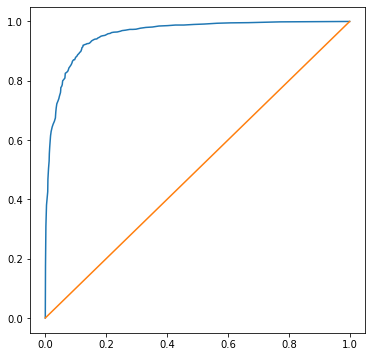

In [42]:
plt.figure(figsize = [6,6])
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])

# customer analysis

In [43]:
os.listdir()

['.config',
 'online_retail_II.xlsx',
 'rfm_test.csv',
 'ecommerce-data.csv',
 'retail_data_response.csv',
 'retail_data_transactions.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'sample_data']

In [44]:
df = pd.read_csv('retail_data_transactions.csv')
df.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [45]:
df.trans_date = pd.to_datetime(df.trans_date)
df.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [46]:
df = df.sort_values(['customer_id', 'trans_date'], ascending = [0,1])
df.head()

,customer_id,trans_date,tran_amount
103506,CS9000,2011-09-04,16
103206,CS9000,2011-10-23,23
110180,CS9000,2012-05-12,53
106580,CS9000,2012-05-23,77
123448,CS9000,2012-06-01,37


In [47]:
df['month'] = df['trans_date'].to_numpy().astype('datetime64[M]')
df.head()

,customer_id,trans_date,tran_amount,month
103506,CS9000,2011-09-04,16,2011-09-01
103206,CS9000,2011-10-23,23,2011-10-01
110180,CS9000,2012-05-12,53,2012-05-01
106580,CS9000,2012-05-23,77,2012-05-01
123448,CS9000,2012-06-01,37,2012-06-01


In [48]:
list_pu = df.groupby(['customer_id', 'month']).first().reset_index()
list_npu = df.groupby(['customer_id']).first().reset_index()

In [51]:
list_month = list_pu['month'].sort_values().unique()

In [61]:
for mon in list_month : 
  
  temp_npu = list_npu[list_npu['month'] == mon]
  temp_pu = list_pu[list_pu['customer_id'].isin(temp_npu['customer_id'])]
  temp_pu = temp_pu.groupby(['month'])['customer_id'].count().reset_index()
  temp_pu = temp_pu.assign(npu_month = mon,
                num = [f'm{a:02d}' for a in range(1, len(temp_pu) +1)]
                )
  temp = temp_pu[['npu_month', 'num', 'customer_id']]
  temp.columns = ['npu_month', 'num', 'pu']
  
  if mon == list_month[0] :

    res = temp

  else : 

    res = pd.concat([res, temp], axis = 0)

res.head()

,npu_month,num,pu
0,2011-05-01,m01,1344
1,2011-05-01,m02,426
2,2011-05-01,m03,460
3,2011-05-01,m04,491
4,2011-05-01,m05,448


In [62]:
pd.pivot_table(res, index = 'npu_month', columns = 'num', values = 'pu').reset_index()

num,npu_month,m01,m02,m03,m04,m05,m06,m07,m08,m09,...,m38,m39,m40,m41,m42,m43,m44,m45,m46,m47
0,2011-05-01,1344.0,426.0,460.0,491.0,448.0,489.0,403.0,458.0,457.0,...,457.0,477.0,441.0,438.0,465.0,433.0,425.0,460.0,411.0,262.0
1,2011-06-01,1804.0,580.0,612.0,580.0,607.0,563.0,586.0,607.0,567.0,...,592.0,623.0,561.0,579.0,586.0,606.0,577.0,520.0,325.0,NaN
2,2011-07-01,1215.0,416.0,413.0,425.0,387.0,424.0,390.0,387.0,397.0,...,403.0,391.0,397.0,406.0,381.0,433.0,374.0,208.0,NaN,NaN
3,2011-08-01,863.0,265.0,280.0,259.0,284.0,293.0,282.0,277.0,264.0,...,256.0,276.0,292.0,308.0,272.0,289.0,181.0,NaN,NaN,NaN
4,2011-09-01,467.0,133.0,139.0,169.0,168.0,142.0,150.0,150.0,144.0,...,171.0,150.0,147.0,144.0,133.0,97.0,NaN,NaN,NaN,NaN
5,2011-10-01,379.0,124.0,128.0,114.0,138.0,119.0,120.0,128.0,111.0,...,132.0,125.0,108.0,100.0,82.0,NaN,NaN,NaN,NaN,NaN
6,2011-11-01,242.0,73.0,71.0,60.0,72.0,71.0,79.0,83.0,96.0,...,71.0,93.0,80.0,42.0,NaN,NaN,NaN,NaN,NaN,NaN
7,2011-12-01,187.0,59.0,62.0,50.0,53.0,72.0,55.0,65.0,57.0,...,61.0,62.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2012-01-01,106.0,27.0,31.0,30.0,33.0,26.0,37.0,35.0,33.0,...,30.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2012-02-01,72.0,23.0,16.0,19.0,23.0,17.0,23.0,20.0,32.0,...,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
res2 = res.assign(ratio = res.groupby(['npu_month'])['pu'].apply(lambda x : x/x.max()))
pd.pivot_table(res2, index = 'npu_month', columns = 'num', values = 'ratio').reset_index()

num,npu_month,m01,m02,m03,m04,m05,m06,m07,m08,m09,...,m38,m39,m40,m41,m42,m43,m44,m45,m46,m47
0,2011-05-01,1.0,0.316964,0.342262,0.365327,0.333333,0.363839,0.299851,0.340774,0.340030,...,0.340030,0.354911,0.328125,0.325893,0.345982,0.322173,0.316220,0.342262,0.305804,0.19494
1,2011-06-01,1.0,0.321508,0.339246,0.321508,0.336475,0.312084,0.324834,0.336475,0.314302,...,0.328160,0.345344,0.310976,0.320953,0.324834,0.335920,0.319845,0.288248,0.180155,NaN
2,2011-07-01,1.0,0.342387,0.339918,0.349794,0.318519,0.348971,0.320988,0.318519,0.326749,...,0.331687,0.321811,0.326749,0.334156,0.313580,0.356379,0.307819,0.171193,NaN,NaN
3,2011-08-01,1.0,0.307068,0.324450,0.300116,0.329085,0.339513,0.326767,0.320973,0.305910,...,0.296640,0.319815,0.338355,0.356895,0.315180,0.334878,0.209733,NaN,NaN,NaN
4,2011-09-01,1.0,0.284797,0.297645,0.361884,0.359743,0.304069,0.321199,0.321199,0.308351,...,0.366167,0.321199,0.314775,0.308351,0.284797,0.207709,NaN,NaN,NaN,NaN
5,2011-10-01,1.0,0.327177,0.337731,0.300792,0.364116,0.313984,0.316623,0.337731,0.292876,...,0.348285,0.329815,0.284960,0.263852,0.216359,NaN,NaN,NaN,NaN,NaN
6,2011-11-01,1.0,0.301653,0.293388,0.247934,0.297521,0.293388,0.326446,0.342975,0.396694,...,0.293388,0.384298,0.330579,0.173554,NaN,NaN,NaN,NaN,NaN,NaN
7,2011-12-01,1.0,0.315508,0.331551,0.267380,0.283422,0.385027,0.294118,0.347594,0.304813,...,0.326203,0.331551,0.192513,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2012-01-01,1.0,0.254717,0.292453,0.283019,0.311321,0.245283,0.349057,0.330189,0.311321,...,0.283019,0.179245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2012-02-01,1.0,0.319444,0.222222,0.263889,0.319444,0.236111,0.319444,0.277778,0.444444,...,0.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
res2.head()

,npu_month,num,pu,ratio
0,2011-05-01,m01,1344,1.000000
1,2011-05-01,m02,426,0.316964
2,2011-05-01,m03,460,0.342262
3,2011-05-01,m04,491,0.365327
4,2011-05-01,m05,448,0.333333


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


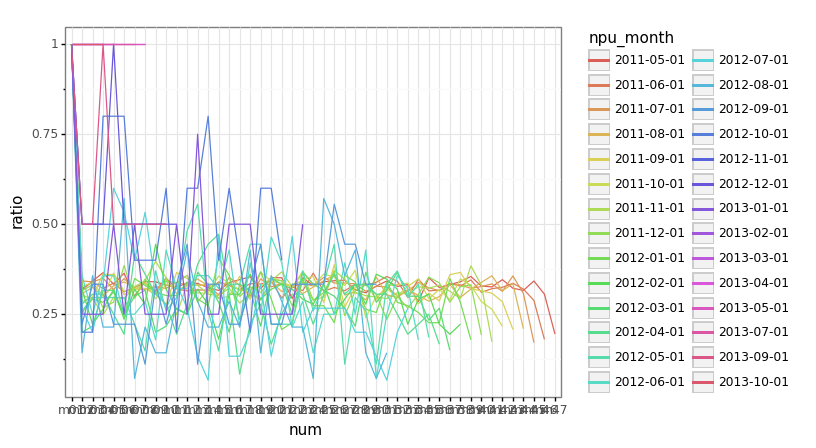

<ggplot: (8753876277057)>

In [69]:
(
    ggplot(res2.assign(npu_month = res2.npu_month.astype(str)),
           aes('num', 'ratio', color = 'npu_month', group = 'npu_month')
           ) +
    gg.geom_line() +
    gg.theme_bw()
)